In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense
from tensorflow.keras import Model
from pandas.api.types import CategoricalDtype
from data_cleaning import load_data, get_score_columns, construct_game_df, convert_date_to_days_ago, get_team_games, points_calc

from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
from joblib import dump, load

from os import listdir
from os.path import isdir, isfile, join


In [2]:
folder = '../data/raw/2014-2019'
files = [f for f in listdir(folder) if isfile(join(folder, f)) and 'Playoff' not in f]

In [3]:
df = load_data(folder)

In [4]:
df.drop(df.index[df['date']==pd.datetime(2020,1,24)], axis=0, inplace=True)

In [6]:
game_cols = ['date', 'TipTime', 'teamid', 'OpponentID', 'Spread', 'ProjectedTotal', 'AwayScore', 'HomeScore', 'season']
box_score_cols = ['SecondsPlayed', 'Two_PM', 'Two_PA', 'Three_PM', 'Three_PA', 'FTM', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PFouls', 'PlusMinus']
game_data_cols = ['TipTime', 'HomeScore_Vegas', 'AwayScore_Vegas', 'Home_days_ago_home', 'Home_days_ago_away', 'Away_days_ago_home', 'Away_days_ago_away']

In [7]:
df_games_scores = get_score_columns(construct_game_df(df, game_cols))
team_games = get_team_games(df_games_scores)
df_game_data = convert_date_to_days_ago(df_games_scores, team_games)

In [44]:
df_game_data[df_game_data['season']<201920]

,date,TipTime,teamid,OpponentID,Spread,ProjectedTotal,AwayScore,HomeScore,season,HomeID,AwayID,HomeScore_Vegas,AwayScore_Vegas,Home_days_ago_home,Home_days_ago_away,Away_days_ago_home,Away_days_ago_away
gameID,,,,,,,,,,,,,,,,,
10271,2014-10-28,0.83,19,22,-18.035072,204.197637,84,101,201415,19,22,105.00,103.00,0.0,0.0,0.0,0.0
10272,2014-10-28,0.83,27,7,11.636669,195.087621,100,101,201415,27,7,105.00,103.00,0.0,0.0,0.0,0.0
10273,2014-10-28,0.94,14,11,16.476360,202.327675,108,90,201415,14,11,105.00,103.00,0.0,0.0,0.0,0.0
10274,2014-10-29,0.79,4,17,-1.555129,204.270242,106,108,201415,4,17,105.00,103.00,1.0,1.0,1.0,1.0
10275,2014-10-29,0.83,20,5,19.479833,187.245957,104,80,201415,20,5,105.00,103.00,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16744,2019-04-10,0.83,1,12,-5.500000,223.500000,135,134,201819,1,12,114.50,109.00,7.0,3.0,3.0,7.0
16745,2019-04-10,0.83,20,9,8.500000,205.500000,115,89,201819,20,9,98.50,107.00,3.0,1.0,1.0,5.0
16746,2019-04-10,0.83,17,21,4.000000,227.000000,127,116,201819,17,21,111.50,115.50,3.0,6.0,1.0,3.0


In [45]:
# game_scaler = RobustScaler().fit(df_game_data[df_game_data['season']<201920][game_data_cols])
# dump(game_scaler, '../models/game_scaler')

['../models/game_scaler']

In [46]:
game_scaler = load('../models/game_scaler')

In [8]:
current_players = df.playerID.unique()
df['PlayerID'] = df.playerID.astype("category", CategoricalDtype(categories=current_players)).cat.codes
df.head()

,date,Player,playerID,salary,PG,SG,SF,PF,C,GS,...,teamid,OpponentID,Spread,ProjectedTotal,AwayScore,HomeScore,Result,season,gameID,PlayerID
0,2014-10-28,Andrew Nicholson,nichoan01,3000,0,0,0,1,0,0,...,22,19,-16.016254,195.174313,84,101,L,201415,10271,694
1,2014-10-28,Moe Harkless,harklma01,4300,0,0,1,1,0,0,...,22,19,-3.093014,182.660174,84,101,L,201415,10271,380
2,2014-10-28,Jeff Withey,witheje01,3000,0,0,0,0,1,0,...,19,22,-18.035072,204.197637,84,101,W,201415,10271,1007
3,2014-10-28,Nikola Vucevic,vucevni01,7600,0,0,0,0,1,1,...,22,19,-19.943198,184.318039,84,101,L,201415,10271,942
4,2014-10-28,John Salmons,salmojo01,3000,0,0,1,0,0,0,...,19,22,-19.461432,182.018669,84,101,W,201415,10271,827


In [9]:
pos_cols = ['PG', 'SG', 'SF', 'PF', 'C']
pos_mat = df[pos_cols].values
df['position'] = (pos_mat / np.maximum(1, np.sum(pos_mat, axis=1, keepdims=True))) @ \
    np.expand_dims(np.array([0, 1, 2, 3, 4]), axis=1)

In [10]:
df = df.sort_values(by=['gameID', 'teamid', 'GS', 'position'], 
                    ascending=[True, True, False, True])
df.reset_index(drop=True, inplace=True)
df.head()

,date,Player,playerID,salary,PG,SG,SF,PF,C,GS,...,OpponentID,Spread,ProjectedTotal,AwayScore,HomeScore,Result,season,gameID,PlayerID,position
0,2014-10-28,Jrue Holiday,holidjr01,7800,1,0,0,0,0,1,...,22,-10.576035,196.377597,84,101,W,201415,10271,425,0.0
1,2014-10-28,Eric Gordon,gordoer01,5200,0,1,0,0,0,1,...,22,-16.097080,184.074737,84,101,W,201415,10271,346,1.0
2,2014-10-28,Tyreke Evans,evansty01,6600,0,1,0,0,0,1,...,22,-11.263128,180.423433,84,101,W,201415,10271,290,1.0
3,2014-10-28,Anthony Davis,davisan02,9500,0,0,0,1,0,1,...,22,-17.060871,182.317312,84,101,W,201415,10271,229,3.0
4,2014-10-28,Omer Asik,asikom01,5800,0,0,0,0,1,1,...,22,-18.681272,182.962831,84,101,W,201415,10271,44,4.0


In [11]:
df['DK_points'] = points_calc(df)

In [12]:
# stat_scaler = RobustScaler().fit(df[box_score_cols])
# dump(stat_scaler, '../models/stat_scaler')

In [13]:
stat_scaler = load('../models/stat_scaler')
stat_scaler

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [14]:
scaled_cols = [col+'_scaled' for col in box_score_cols]
scaled_stats = stat_scaler.transform(df[box_score_cols])
df_scaled = pd.DataFrame(scaled_stats, columns=scaled_cols, index=df.index)
df = pd.concat((df, df_scaled), axis=1)

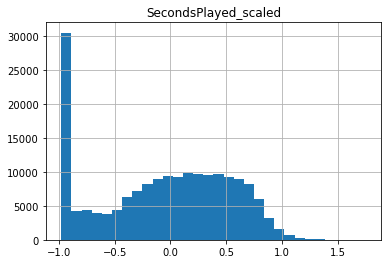

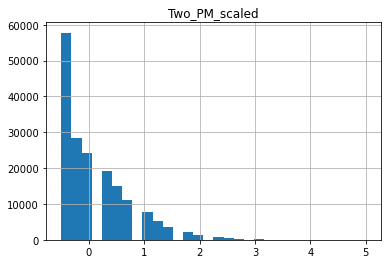

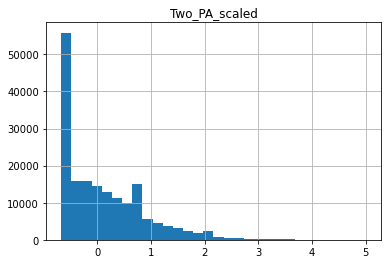

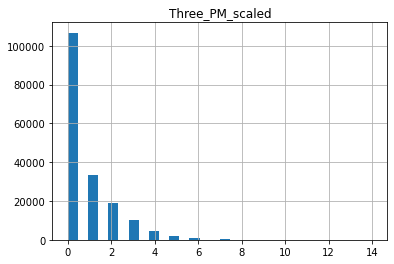

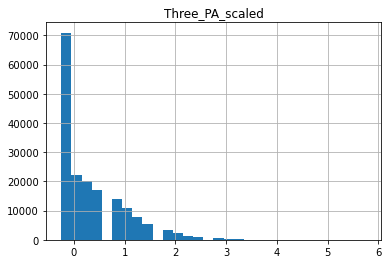

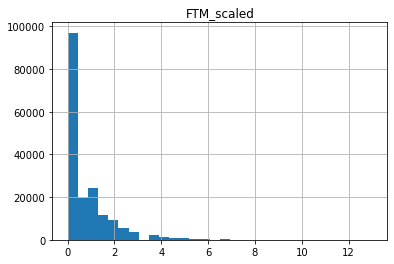

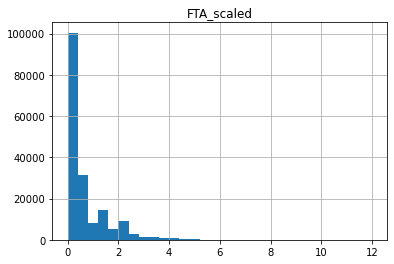

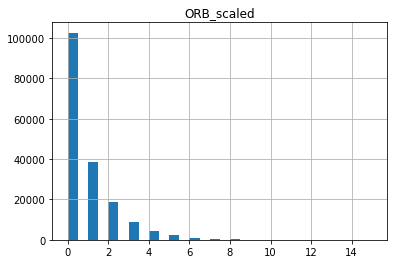

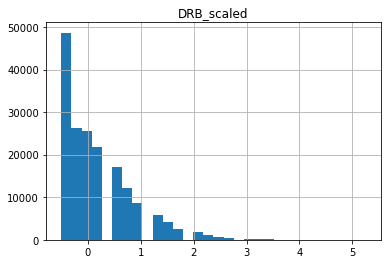

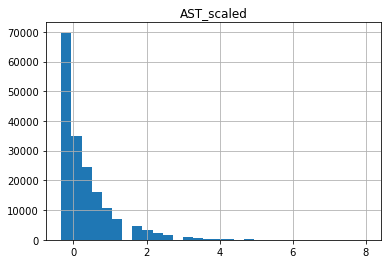

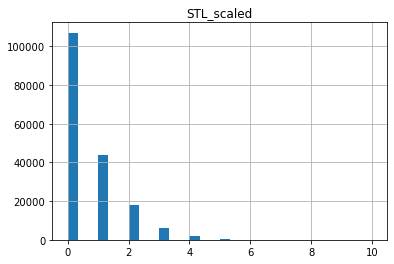

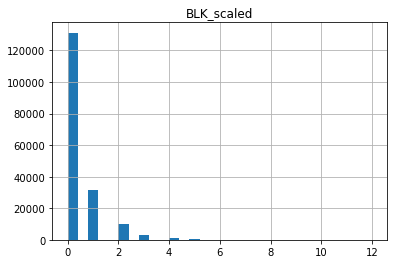

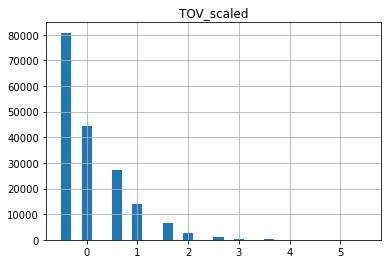

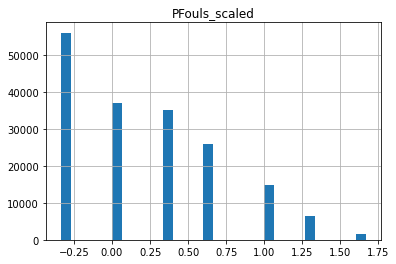

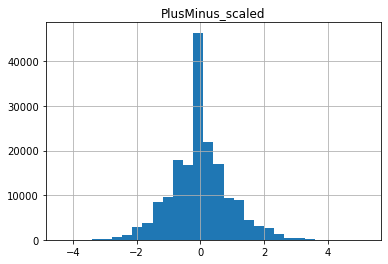

In [15]:
for col in scaled_cols:
    df[col].hist(bins=30)
    plt.title(col)
    plt.show()

In [20]:
class NBAGame():
    
    def __init__(self, gameid, box_cols, n_players=13):
        self.gameid = gameid
        self.n_players = n_players
        self.box_cols = box_cols
            
    def get_game_data(self, df, game_data):
        self.df = df[df['gameID']==self.gameid]
        self.df.index = self.df['playerID']
        self.game_data = game_data
        self.date = pd.to_datetime(self.df.iloc[0]['date'])
    
    def check_lineup(self):
        home_starters = np.sum(self.df[(self.df['GS']==1) & (self.df['Home']==1)]['GS'].values)
        away_starters = np.sum(self.df[(self.df['GS']==1) & (self.df['Home']==0)]['GS'].values)
        home_mins = np.sum(self.df[self.df['Home']==1]['SecondsPlayed'].values)/60
        away_mins = np.sum(self.df[self.df['Home']==0]['SecondsPlayed'].values)/60
        home_players = self.df[self.df['Home']==1].shape[0]
        away_players = self.df[self.df['Home']==0].shape[0]
        if home_players > 13:
            print('Home team game '+str(self.gameid)+' has '+str(home_players)+' players')
        if away_players > 13:
            print('Away team game '+str(self.gameid)+' has '+str(away_players)+' players')
        if home_starters != 5:
            print('Home team game '+str(self.gameid)+' has '+str(home_starters)+' starters')
        if away_starters != 5:
            print('Away team game '+str(self.gameid)+' has '+str(away_starters)+' starters')
        if home_mins < 48:
            print('Home team game '+str(self.gameid)+' has '+str(home_mins)+' minutes')
        if away_mins < 48:
            print('Away team game '+str(self.gameid)+' has '+str(away_mins)+' minutes')
        
    def add_players(self, df_extra):
        home = self.df[self.df['Home']==1]
        away = self.df[self.df['Home']==0]
        home_adds = self.n_players - home.shape[0]
        away_adds = self.n_players - away.shape[0]
        if home_adds + away_adds != 0:
            df_extras = pd.concat([df_extra]*(home_adds+away_adds), axis=0)
            df_extras['Home'] = np.array(home_adds*[1]+[0]*away_adds)
            df_extras['position'] = np.random.choice(5, size=(home_adds+away_adds))
            self.df = pd.concat((self.df, df_extras), axis=0)
            self.lineup_sort()

    def lineup_sort(self):
        self.df = self.df.sort_values(by=['Home', 'GS', 'position'], 
                                      ascending=[False, False, True])


In [21]:
NBA_games = {}
for game in df.gameID.unique():
    NBA_games[game] = NBAGame(game, scaled_cols)

In [22]:
df_extra = df.iloc[9:10]
df_extra.loc[9, ['Player', 'playerID']] = ['Extra Player', 'extra01']
df_extra

,date,Player,playerID,salary,PG,SG,SF,PF,C,GS,...,FTM_scaled,FTA_scaled,ORB_scaled,DRB_scaled,AST_scaled,STL_scaled,BLK_scaled,TOV_scaled,PFouls_scaled,PlusMinus_scaled
9,2014-10-28,Extra Player,extra01,3000,0,0,1,1,0,0,...,0.0,0.0,0.0,-0.5,-0.333333,0.0,0.0,-0.5,-0.333333,0.0


In [23]:
for game in list(NBA_games.keys()):
    NBA_games[game].get_game_data(df, df_game_data.loc[game])
    NBA_games[game].check_lineup()
    NBA_games[game].add_players(df_extra)

In [50]:
game_data_train = []
game_data_test = []
for game in list(NBA_games.keys()):
    scaled_game_data = game_scaler.transform(df_game_data.loc[game, game_data_cols].values.reshape(1, -1))
    data = NBA_games[game].df[scaled_cols].values.flatten()
    data = np.append(data, scaled_game_data)
    if NBA_games[game].date < pd.datetime(2019, 10, 20):
        game_data_train += [data]
    else:
        game_data_test += [data]
game_data_train = np.stack(game_data_train)
game_data_test = np.stack(game_data_test)

In [51]:
def build_encoder(X_len, enc_dim, bottleneck, activations):

    X = Input(shape=(X_len,))
    X_int = Dense(enc_dim)(X)
    X_int = Activation(activations)(X_int)
    Enc = Dense(bottleneck)(X_int)

    encoder = Model(inputs=[X], outputs=[Enc])

    return encoder

def build_decoder(Y_len, dec_dim, bottleneck, activations):
    
    Enc = Input(shape=(bottleneck,))
    Enc_act = Activation(activations)(Enc)
    Y_int = Dense(dec_dim)(Enc_act)
    Y_int = Activation(activations)(Y_int)
    Y = Dense(Y_len)(Y_int)

    decoder = Model(inputs=[Enc], outputs=[Y])
    
    return decoder

def build_encoder_decoder(X_len, Y_len, enc_dim, dec_dim,
                          bottleneck, activations='Linear'):

    encoder = build_encoder(X_len, enc_dim, bottleneck, activations)
    decoder = build_decoder(Y_len, dec_dim, bottleneck, activations)
    Y = decoder(encoder.output)

    model = Model(inputs=encoder.input,
                  outputs=Y)
    return model

In [60]:
X_len = Y_len = game_data_train.shape[-1]
enc_dim = dec_dim = 128
bottleneck = 64
activations = 'tanh'

In [61]:
NBA_autoencoder = build_encoder_decoder(X_len, Y_len, enc_dim, dec_dim, bottleneck, activations)

In [73]:
NBA_autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['accuracy'])

log_dir = "logs\\fit\\" + pd.datetime.now().strftime("%Y%m%d-%H%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=100)

In [74]:
NBA_autoencoder.fit(x=game_data_train, 
                    y=game_data_train, 
                    batch_size=game_data_train.shape[0],
                    epochs=100,
                    validation_data=(game_data_test, game_data_test), 
                    callbacks=[tensorboard_callback])

Train on 6138 samples, validate on 950 samples
Epoch 1/100
6138/6138 [==============================] - 1s 106us/sample - loss: 0.2893 - accuracy: 0.5406 - val_loss: nan - val_accuracy: 0.4611
Epoch 2/100
6138/6138 [==============================] - 0s 18us/sample - loss: 0.3227 - accuracy: 0.4998 - val_loss: nan - val_accuracy: 0.5084
Epoch 3/100
6138/6138 [==============================] - 0s 14us/sample - loss: 0.2899 - accuracy: 0.5355 - val_loss: nan - val_accuracy: 0.5347
Epoch 4/100
6138/6138 [==============================] - 0s 16us/sample - loss: 0.2975 - accuracy: 0.5543 - val_loss: nan - val_accuracy: 0.5316
Epoch 5/100
6138/6138 [==============================] - 0s 15us/sample - loss: 0.3045 - accuracy: 0.5510 - val_loss: nan - val_accuracy: 0.5158
Epoch 6/100
6138/6138 [==============================] - 0s 13us/sample - loss: 0.2982 - accuracy: 0.5455 - val_loss: nan - val_accuracy: 0.5021
Epoch 7/100
6138/6138 [==============================] - 0s 15us/sample - loss: 0.

In [ ]:
home_box_scores_pm, away_box_scores_pm, N_players = get_box_scores(df_spm_scaled, box_score_cols, 
                                                                   spm_scaler, player_ids.shape[0], 5)

In [ ]:
home_box_scores, away_box_scores, N_players = get_box_scores(df_scaled, box_score_cols, 
                                                             stat_scaler, player_ids.shape[0], last_games=5)

In [ ]:
home_scores, away_scores = get_scores(df)

In [ ]:
#last_cols = [col for col in home_box_scores[14400] if 'last' in col]
#pca_mtx = np.zeros((0, len(last_cols)))
#for game in np.array(df_days_ago.index)[1000:3000]:
#    pca_mtx = np.concatenate((pca_mtx,
#                              home_box_scores[game][last_cols].values,
#                              away_box_scores[game][last_cols].values),
#                             axis=0)
    
#pca_pm_mtx = np.zeros((0, len(last_cols)))
#for game in np.array(df_days_ago.index)[1000:3000]:
#    pca_pm_mtx = np.concatenate((pca_pm_mtx,
#                              home_box_scores_pm[game][last_cols].values,
#                              away_box_scores_pm[game][last_cols].values),
#                             axis=0)

In [ ]:
#pca_pm = load('../models/pca_pm')
#pca = load('../models/pca')
PLS = load('../models/pls')

In [ ]:
#pca = PCA().fit(pca_mtx)
#pca_pm = PCA().fit(pca_pm_mtx)
#dump(pca, '../models/pca10')
#dump(pca_pm, '../models/pca_pm10')
#dump(PLS, '../models/pls')

In [ ]:
#y_mtx = np.zeros((0, len(box_score_cols)))
#for game in np.array(df_days_ago.index)[1000:3000]:
#    y_mtx = np.concatenate((y_mtx,
#                            home_box_scores[game][box_score_cols].values,
#                            away_box_scores[game][box_score_cols].values),
#                            axis=0)

In [ ]:
#PLS = PLSRegression(4).fit(pca_mtx, y_mtx)

In [ ]:
#print(np.sum(pca.explained_variance_ratio_[:5]))
#print(pca_pm.explained_variance_ratio_)

In [ ]:
non_pc_cols = [col for col in home_box_scores[14400].columns if 'PC' not in col]

In [ ]:
N_comps = 4
last_cols = [col for col in home_box_scores[14400].columns if 'last' in col]
for game in np.array(df_days_ago.index):
    #PC_cols = pca_pm.transform(home_box_scores_pm[game][last_cols])[:,:N_comps]
    #df_home_pcs = pd.DataFrame(PC_cols,
    #                           columns=['PC '+str(i+1) for i in range(N_comps)],
    #                           index=home_box_scores[game].index)
    #home_box_scores[game] = pd.concat((home_box_scores[game][non_pc_cols],
    #                                   df_home_pcs), axis=1)
    #PC_cols = pca_pm.transform(away_box_scores_pm[game][last_cols])[:,:N_comps]
    #df_away_pcs = pd.DataFrame(PC_cols,
    #                           columns=['PC '+str(i+1) for i in range(N_comps)],
    #                           index=away_box_scores[game].index)
    #away_box_scores[game] = pd.concat((away_box_scores[game][non_pc_cols],
    #                                   df_away_pcs), axis=1)
    PC_cols = PLS.transform(home_box_scores[game][last_cols])[:,:N_comps]
    df_home_pcs = pd.DataFrame(PC_cols,
                               columns=['PC '+str(i+1) for i in range(N_comps)],
                               index=home_box_scores[game].index)
    home_box_scores[game] = pd.concat((home_box_scores[game][non_pc_cols],
                                       df_home_pcs), axis=1)
    PC_cols = PLS.transform(away_box_scores[game][last_cols])[:,:N_comps]
    df_away_pcs = pd.DataFrame(PC_cols,
                               columns=['PC '+str(i+1) for i in range(N_comps)],
                               index=away_box_scores[game].index)
    away_box_scores[game] = pd.concat((away_box_scores[game][non_pc_cols],
                                       df_away_pcs), axis=1)

In [ ]:
N_scores = 7
def get_score_one_hot(box_score, score_vec=10*(np.arange(N_scores)+1)):
    points = box_score['DK_points']
    for score in score_vec:
        over_threshold_bool = (points > score) + 0.0
        box_score['over '+str(score)] = over_threshold_bool
    return box_score

In [ ]:
for game in np.array(df_days_ago.index):
    home_box_scores[game] = get_score_one_hot(home_box_scores[game])
    away_box_scores[game] = get_score_one_hot(away_box_scores[game])

In [ ]:
class MakeMTXLayer(tf.keras.layers.Layer):
    
    def __init__(self, n_players, players, player_states, inputs, game_states, 
                 games_in_batch, kernel_regularizer, initA=0.8):
        super(MakeMTXLayer, self).__init__()
        self.players = players
        self.player_states = player_states
        self.inputs = inputs
        self.games_in_batch = games_in_batch
        self.regularizer = kernel_regularizer
        self.initA = initA
        
    def build(self, input_shape ):
        
        #self.stateMTX_A = self.add_variable("stateMTX_A",
        #                                    shape=[self.player_states*self.players*2, 
        #                                           self.player_states*self.players*2],
        #                                    initializer=tf.keras.initializers.Identity(gain=self.initA))
        self.stateMTX_A = self.add_variable("stateMTX_A",
                                            shape=[self.player_states*self.players*2, 
                                                   1],
                                            initializer=tf.keras.initializers.Constant(value=self.initA))
        self.stateMTX_B = self.add_variable("stateMTX_B",
                                            shape=[self.player_states*self.players*2, 
                                                   self.inputs*self.players*2])
    
    def call(self, input):
        A = tf.expand_dims(tf.stack([self.stateMTX_A for i in range(self.games_in_batch)]),0)
        B = tf.expand_dims(tf.stack([self.stateMTX_B for i in range(self.games_in_batch)]),0)
        self.add_loss(self.regularizer(B))
        return input, A, B

class PredictionLayer(tf.keras.layers.Layer):
    
    def __init__(self, players, player_states, inputs, outputs, game_states, kernel_regularizer):
        super(PredictionLayer, self).__init__()
        self.players = players
        self.player_states = player_states
        self.inputs = inputs
        self.outputs = outputs
        self.game_states = game_states
        self.regularizer = kernel_regularizer
        
    def build( self, input_shape ):
        
        self.bias = self.add_variable("bias", 
                                      shape=[self.outputs*self.players*2, 1])
        
        self.game_kernel = self.add_variable("game_kernel", 
                                             shape=[self.outputs*self.players*2, self.game_states])
        
        self.stateMTX_C = self.add_variable("output_kernel", 
                                            shape=[self.outputs*self.players*2, 
                                                   (self.player_states+self.inputs)*self.players*2])
    
    def call(self, inputs):
        [x, p, s, z] = inputs
        xp = self.get_game_states(x, p, s)
        self.add_loss(self.regularizer(self.stateMTX_C))
        self.add_loss(self.regularizer(self.game_kernel))
        return tf.matmul(self.stateMTX_C, xp) + tf.matmul(self.game_kernel, z) + self.bias
    
    def get_game_states(self, states, players_in_game, princ_comps):
        batch_size = players_in_game.shape[0]
        games_in_batch = players_in_game.shape[1]
        state = tf.gather_nd(states[0,0], players_in_game[0,0])
        for i in range(1, games_in_batch):
            state = tf.concat((state, tf.gather_nd(states[0,i], players_in_game[0,i])), axis=0)
        statef = tf.reshape(state, (batch_size, games_in_batch, self.players*2, self.player_states))
        for j in range(1,batch_size):
            state = tf.gather_nd(states[j,0], players_in_game[j,0])
            for i in range(1, games_in_batch):
                state = tf.concat((state, tf.gather_nd(states[j,i], players_in_game[j,i])), axis=0)
            state = tf.reshape(state, (batch_size, games_in_batch, self.players*2, self.player_states))
            statef = tf.concat((statef, state), axis=0)
        statef = tf.concat((statef, princ_comps), axis=-1)
        state = tf.reshape(statef, (batch_size, games_in_batch, 
                                    (self.player_states+self.inputs)*self.players*2, 1))
        return state
    
class GameCell(tf.keras.layers.Layer):
        
    def __init__(self, n_players, players, player_states, inputs, game_states):
        super(GameCell, self).__init__()
        self.players = players
        self.player_states = player_states
        self.inputs = inputs
        self.state_size = tf.TensorShape([n_players, player_states])
        self.output_size = tf.TensorShape([n_players, player_states])
        
    def build(self, input_shape ):
        self.built=True
    
    def call(self, inputs, state):
        u, p, A, B = inputs
        #A = tf.squeeze(A)
        B = tf.squeeze(B)
        state = state[0] + tf.zeros((state[0].shape))
        xp = self.get_game_states(state, p)
        u = tf.reshape(u, (u.shape[0],self.players*2*self.inputs,1))
        #xp_plus = tf.matmul(A, xp) + tf.matmul(B, u)
        xp_plus = A*xp + tf.matmul(B, u)
        state = self.update_states(state, p, xp_plus, xp)
        return state, [state]
    
    def get_game_states(self, states, players_in_game):
        batch_size = players_in_game.shape[0]
        state = tf.gather_nd(states[0], players_in_game[0])
        for i in range(1,batch_size):
            state = tf.concat((state, tf.gather_nd(states[i], players_in_game[i])), axis=0)
        state = tf.reshape(state, (batch_size, -1, 1))
        return state
    
    def update_states(self, states, players_in_game, xp_plus, xp):
        batch_size = players_in_game.shape[0]
        state_change = xp_plus - xp
        state_change = tf.reshape(state_change, ((state_change.shape[0], self.players*2,-1)))
        sparse_tensor = states[0] + tf.scatter_nd(players_in_game[0], state_change[0], states[0].shape)
        for i in range(1,batch_size):
            sparse_tensor = tf.concat((sparse_tensor,tf.scatter_nd(players_in_game[i], state_change[i], states[i].shape)),axis=0)
        states = tf.reshape(sparse_tensor, (batch_size, -1, self.player_states))
        return states
    
class GameRNN(RNN):
    
    def __init__(self,
                 n_players,
                 players, 
                 player_states, 
                 inputs, 
                 game_states,
                 return_sequences=True,
                 return_state=False,
                 stateful=True,
                 unroll=False
                ):
        self.n_players = n_players
        self.players = players
        self.player_states = player_states
        self.inputs = inputs
        self.game_states = game_states
        cell = GameCell(n_players, players, player_states, inputs, game_states)
        super(GameRNN, self).__init__(
            cell,
            return_sequences=return_sequences,
            return_state=return_state,
            stateful=stateful,
            unroll=unroll)
        
    def call(self, inputs, initial_state=None, constants=None):
        return super(GameRNN, self).call(inputs, initial_state=initial_state, constants=constants)
    

In [ ]:
def build_game_model( 
        n_players, players_per_game, player_states, game_states, 
        inputs, summary_stats, outputs, games_in_batch, batch_size, 
        l2, hidden_size, N_scores):
    
    '''
    This function builds the tensorflow model.
    '''
    
    p = Input(batch_shape = (batch_size, games_in_batch, players_per_game*2, 1), dtype=tf.int32)
    
    u_in = Input(batch_shape = (batch_size, games_in_batch, players_per_game*2, inputs))
    
    u, A, B = MakeMTXLayer(n_players, players_per_game, player_states, 
                           inputs, game_states, games_in_batch, tf.keras.regularizers.l2(l2))(u_in)
    
    x_plus = GameRNN(n_players, players_per_game, player_states, 
                     inputs, game_states)(tuple([u, p, A, B]))
    
    p_plus = Input(batch_shape = (batch_size, games_in_batch, players_per_game*2, 1), dtype=tf.int32)
    
    s_plus = Input(batch_shape = (batch_size, games_in_batch, players_per_game*2, summary_stats))
    
    z_plus = Input(batch_shape = (batch_size, games_in_batch, game_states, 1))
    
    y_plus = PredictionLayer(players_per_game, player_states, summary_stats, outputs, 
                        game_states, tf.keras.regularizers.l2(l2))([x_plus, p_plus, s_plus, z_plus])
    
    y_plus2 = PredictionLayer(players_per_game, player_states, summary_stats, N_scores, 
                        game_states, tf.keras.regularizers.l2(l2))([x_plus, p_plus, s_plus, z_plus])
    
    #y_plus = PredictionLayer(players_per_game, player_states, summary_stats, hidden_size, 
    #                    game_states, tf.keras.regularizers.l2(l2))([x_plus, p_plus, s_plus, z_plus])
    
    #y_plus = Activation('tanh')(y_plus)
    
    #y_plus = Reshape((games_in_batch, players_per_game*2 * hidden_size))(y_plus)
    
    #y_plus = Dropout(0.2)(y_plus)#, training=True)
    
    #y_plus = Dense(outputs*players_per_game*2)(y_plus)
    
    y_plus_out = Reshape((games_in_batch, players_per_game*2, outputs))(y_plus)
    
    y_plus2 = Reshape((games_in_batch, players_per_game*2*N_scores))(y_plus2)
    
    dist_plus = Activation('sigmoid')(y_plus2)
    
    dist_plus = Reshape((games_in_batch, players_per_game*2, N_scores))(dist_plus)
    
    model = Model(inputs = [p, u_in, p_plus, s_plus, z_plus],
                  outputs = [y_plus_out, dist_plus, x_plus],
                  name='game_model')
    
    return model



In [ ]:
players = 13
player_states = 6
hidden_size = 30
N_comps = 4
inputs = len(box_score_cols)
outputs = len(box_score_cols)
game_states = 7
games_in_batch = 128
batch_size = 1
l2 = 0.000001
training_games = [game for game in df_spm_scaled.gameID.unique() if game < 18000]#< 16200]
test_games = [game for game in df_spm_scaled.gameID.unique() if game >= 14500]
games_in_batch_test = len(test_games)-1

In [ ]:
N_players = 2168

In [ ]:

rnn = build_game_model(N_players, players, player_states, game_states, inputs, N_comps,
                       outputs, games_in_batch, batch_size, l2, hidden_size, N_scores)
                      


In [ ]:
rnn.load_weights('../models/rnn_model_weights25030')

In [ ]:
A = np.load('../models/A_mtx_rnnv2.5.npy')
B = np.load('../models/B_mtx_rnnv2.5.npy')

state_layer = [rnn.layers[i] for i in range(len(rnn.layers)) if 'mtx' in rnn.layers[i].name][0]
state_layer.set_weights([A, B])
state_layer.trainable = False

In [ ]:
rnn.summary()

In [ ]:
training_game_data = np.stack( [df_days_ago.loc[game, game_data_cols].values for game in training_games], axis=0)
game_scaler = MinMaxScaler()
scaled_game_data = game_scaler.fit_transform(training_game_data)

test_game_data = np.stack( [df_days_ago.loc[game, game_data_cols].values for game in test_games], axis=0)
scaled_game_data_test = game_scaler.transform(test_game_data)

In [ ]:
#dump(game_scaler, '../models/game_scaler')

In [ ]:
home_box_scores_tensor = np.stack(
    [home_box_scores[game][box_score_cols].values for game in training_games])
away_box_scores_tensor = np.stack(
    [away_box_scores[game][box_score_cols].values for game in training_games])
box_scores_tensor = np.concatenate((home_box_scores_tensor, away_box_scores_tensor), axis=-2)

home_box_scores_tensor_test = np.stack(
    [home_box_scores[game][box_score_cols].values for game in test_games])
away_box_scores_tensor_test = np.stack(
    [away_box_scores[game][box_score_cols].values for game in test_games])
box_scores_tensor_test = np.concatenate((home_box_scores_tensor_test, away_box_scores_tensor_test), axis=-2)

In [ ]:
home_box_scores_pm_tensor = np.stack(
    [home_box_scores_pm[game][box_score_cols].values for game in training_games])
away_box_scores_pm_tensor = np.stack(
    [away_box_scores_pm[game][box_score_cols].values for game in training_games])
box_scores_pm_tensor = np.concatenate((home_box_scores_pm_tensor, away_box_scores_pm_tensor), axis=-2)

home_box_scores_pm_tensor_test = np.stack(
    [home_box_scores_pm[game][box_score_cols].values for game in test_games])
away_box_scores_pm_tensor_test = np.stack(
    [away_box_scores_pm[game][box_score_cols].values for game in test_games])
box_scores_pm_tensor_test = np.concatenate((home_box_scores_pm_tensor_test, away_box_scores_pm_tensor_test), axis=-2)

In [ ]:
score_vec = 10*(np.arange(N_scores)+1)
over_cols = ['over '+str(score) for score in score_vec]

home_over_tensor = np.stack(
    [home_box_scores[game][over_cols].values for game in training_games])
away_over_tensor = np.stack(
    [away_box_scores[game][over_cols].values for game in training_games])
over_tensor = np.concatenate((home_over_tensor, away_over_tensor), axis=-2)

home_over_tensor_test = np.stack(
    [home_box_scores[game][over_cols].values for game in test_games])
away_over_tensor_test = np.stack(
    [away_box_scores[game][over_cols].values for game in test_games])
over_tensor_test = np.concatenate((home_over_tensor_test, away_over_tensor_test), axis=-2)

In [ ]:
PC_cols = ['PC '+str(i+1) for i in range(N_comps)]

home_pcs_tensor = np.stack(
    [home_box_scores[game][PC_cols].values for game in training_games])
away_pcs_tensor = np.stack(
    [away_box_scores[game][PC_cols].values for game in training_games])
pcs_tensor = np.concatenate((home_pcs_tensor, away_pcs_tensor), axis=-2)

home_pcs_tensor_test = np.stack(
    [home_box_scores[game][PC_cols].values for game in test_games])
away_pcs_tensor_test = np.stack(
    [away_box_scores[game][PC_cols].values for game in test_games])
pcs_tensor_test = np.concatenate((home_pcs_tensor_test, away_pcs_tensor_test), axis=-2)

In [ ]:
pcs_tensor_test.shape

In [ ]:
home_players_tensor = np.stack( 
    [home_box_scores[game].PlayerID.values for game in training_games])
away_players_tensor = np.stack( 
    [away_box_scores[game].PlayerID.values for game in training_games])
players_tensor = np.expand_dims(
    np.concatenate((home_players_tensor, away_players_tensor), axis=-1), axis=2)

home_players_tensor_test = np.stack( 
    [home_box_scores[game].PlayerID.values for game in test_games])
away_players_tensor_test = np.stack( 
    [away_box_scores[game].PlayerID.values for game in test_games])
players_tensor_test = np.expand_dims(
    np.concatenate((home_players_tensor_test, away_players_tensor_test), axis=-1), axis=2)

In [ ]:
game_data_tensor = np.expand_dims(scaled_game_data,axis=2)
game_data_tensor_test = np.expand_dims(scaled_game_data_test,axis=2)

In [ ]:
starting_games = [len(training_games)%games_in_batch-1 + games_in_batch*i 
                  for i in range(len(training_games)//games_in_batch)]
time_series = [range(start,start+games_in_batch) for start in starting_games]
time_series2 = [range(start+1,start+games_in_batch+1) for start in starting_games]

In [ ]:
time_series_test = [range(0,games_in_batch_test)] 
time_series_test2 = [range(1,games_in_batch_test+1)]
                                                                     

In [ ]:
def convert_to_time_series(tensor, time_series_list):
    tensor_list = []
    for i in range(len(time_series_list)):
        tensor_list += [tensor[time_series_list[i]]]
    return np.stack(tensor_list)

In [ ]:
box_scores_tensor_batched = convert_to_time_series(box_scores_tensor, time_series)
#box_scores_pm_tensor_batched = convert_to_time_series(box_scores_pm_tensor, time_series)
players_tensor_batched = convert_to_time_series(players_tensor, time_series)
box_scores_tensor_plus_batched = convert_to_time_series(box_scores_tensor, time_series2)
players_tensor_plus_batched = convert_to_time_series(players_tensor, time_series2)
pcs_tensor_plus_batched = convert_to_time_series(pcs_tensor, time_series2)
game_data_tensor_plus_batched = convert_to_time_series(game_data_tensor, time_series2)
over_tensor_plus_batched = convert_to_time_series(over_tensor, time_series2)

box_scores_tensor_batched_test = convert_to_time_series(box_scores_tensor_test, time_series_test)
#box_scores_pm_tensor_batched_test = convert_to_time_series(box_scores_pm_tensor_test, time_series_test)
players_tensor_batched_test = convert_to_time_series(players_tensor_test, time_series_test)
box_scores_tensor_plus_batched_test = convert_to_time_series(box_scores_tensor_test, time_series_test2)
players_tensor_plus_batched_test = convert_to_time_series(players_tensor_test, time_series_test2)
pcs_tensor_plus_batched_test = convert_to_time_series(pcs_tensor_test, time_series_test2)
game_data_tensor_plus_batched_test = convert_to_time_series(game_data_tensor_test, time_series_test2)
over_tensor_plus_batched_test = convert_to_time_series(over_tensor_test, time_series_test2)

In [ ]:
box_scores_tensor_plus_batched[:,:,:,-1] = box_scores_tensor_plus_batched[:,:,:,-1]/10
box_scores_tensor_plus_batched[:,:,:,0] = box_scores_tensor_plus_batched[:,:,:,0]*1.2

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-(x-0.35)/0.055))

In [ ]:
x = np.linspace(0,1,game_data_tensor_plus_batched.shape[0])
sample_weights_tensor_batched = np.expand_dims(sigmoid(x),axis=1)

plt.plot(x, sample_weights_tensor_batched)

In [ ]:
rnn.layers

In [ ]:
LR = 1e-5
OPT = optimizers.Adam(lr=LR)
#rnn.compile(optimizer=OPT, loss='mean_squared_error', sample_weight_mode="temporal")
rnn.compile(optimizer=OPT, loss=['mean_squared_error', 'binary_crossentropy'], sample_weight_mode="temporal")
rnn.reset_states()

In [ ]:
sw = np.stack([np.squeeze(sample_weights_tensor_batched) for i in range(games_in_batch)])
#sample_weights = [sw.T]
sample_weights = [sw.T, sw.T*2]

In [ ]:
import copy
def lineup_shuffle(X, flip_frac=0.3, reorder_frac=0.2, reorder_dist=45):
    flip_frac = np.random.uniform(0, flip_frac)
    reorder_frac = np.random.uniform(0, reorder_frac)
    reorder_dist = np.random.choice(np.arange(reorder_dist-15))+15
    
    starting_home_position = np.random.choice(3, size=(X[0].shape[1],1))+1
    starting_home_swap = starting_home_position + np.random.choice(3, size=(X[0].shape[1],1))-1
    starting_away_position = np.random.choice(3, size=(X[0].shape[1],1))+14
    starting_away_swap = starting_away_position + np.random.choice(3, size=(X[0].shape[1],1))-1
    bench_home_position = np.random.choice(6, size=(X[0].shape[1],1))+6
    bench_home_swap = bench_home_position + np.random.choice(3, size=(X[0].shape[1],1))-1
    bench_away_position = np.random.choice(6, size=(X[0].shape[1],1))+19
    bench_away_swap = bench_away_position + np.random.choice(3, size=(X[0].shape[1],1))-1
    
    flip_home = np.where((np.random.choice(10, size=(X[0].shape[1],1))+1) < (10*flip_frac))[0]
    flip_away = np.where((np.random.choice(10, size=(X[0].shape[1],1))+1) < (10*flip_frac))[0]
    
    reorder = np.random.choice(X[0].shape[1]-reorder_dist, 
                               size=(int(X[0].shape[1]*reorder_frac)))
    reorder = np.unique(reorder)
    jump = np.random.choice(reorder_dist-14, size=reorder.shape)+15
    targets = reorder + jump
    reorder_idx = np.array([i for i in range(reorder.shape[0]) if reorder[i] not in targets]).astype(int)
    reorder = reorder[reorder_idx]
    targets = targets[reorder_idx]
    
    home_starter_shuffle = np.random.choice(5, size=(flip_home.shape[0]))
    away_starter_shuffle = np.random.choice(5, size=(flip_away.shape[0]))+13
    
    home_bench_shuffle = home_starter_shuffle + 5 + np.random.choice(4, size=(flip_home.shape[0]))
    away_bench_shuffle = away_starter_shuffle + 5 + np.random.choice(4, size=(flip_away.shape[0]))
    
    X_shuffle = []
    for tensor in X:
        #player shift within starting / bench
        tensor[:,np.array([starting_home_position, starting_home_swap])] = \
        tensor[:,np.array([starting_home_swap, starting_home_position])]
        tensor[:,np.array([starting_away_position, starting_away_swap])] = \
        tensor[:,np.array([starting_away_swap, starting_away_position])]
        tensor[:,np.array([bench_home_position, bench_home_swap])] = \
        tensor[:,np.array([bench_home_swap, bench_home_position])]
        tensor[:,np.array([bench_away_position, bench_away_swap])] = \
        tensor[:,np.array([bench_away_swap, bench_away_position])]
        
        #player flip starting / bench
        tensor[:, flip_home, np.array([home_starter_shuffle, home_bench_shuffle])] = \
        tensor[:, flip_home, np.array([home_bench_shuffle, home_starter_shuffle])]
        tensor[:, flip_away, np.array([away_starter_shuffle, away_bench_shuffle])] = \
        tensor[:, flip_away, np.array([away_bench_shuffle, away_starter_shuffle])]
        X_shuffle += [tensor]
        
    X_out = []
    for tensor in X_shuffle[:2]:
        #reorder games
        tensor[:, np.append(targets, reorder)] = tensor[:, np.append(reorder, targets)]
        X_out += [tensor]
    return X_out + X_shuffle[2:]

In [ ]:
for epoch in range(1,1000):
    print("epoch: "+str(epoch))
    X = [players_tensor_batched, box_scores_tensor_batched, 
         players_tensor_plus_batched, pcs_tensor_plus_batched,
         box_scores_tensor_plus_batched, over_tensor_plus_batched]
    X = lineup_shuffle(copy.deepcopy(X))
    rnn.fit(x=[X[0].astype(np.int32),
               X[1].astype(np.float32),
               X[2].astype(np.int32),
               X[3].astype(np.float32),
               game_data_tensor_plus_batched.astype(np.float32)], 
            y=[X[4],
               X[5]],
            sample_weight=sample_weights,
            batch_size=batch_size, epochs=1, verbose=1, shuffle=False)
    rnn.reset_states()
    print('reset states')
    if epoch % 10 == 0:
        save_name = '../models/rnn_model_weights2503'+str(((epoch) // 50))
        rnn.save_weights(save_name)

In [ ]:
#rnn.save_weights('../models/rnn_model_weights206')

In [ ]:

var_name = []
var_vals = {}
for var in rnn.trainable_variables:
    var_name = var.name
    var_vals[var_name] = var.numpy()
var_names = list(var_vals.keys())


In [ ]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 15
for var in var_names:
    plt.imshow(var_vals[var][:,:])
    plt.colorbar()
    plt.title(var)
    plt.show()

In [ ]:
player_states = 6
rnn_test = build_game_model(N_players+1, players, player_states, game_states, 
                            inputs, N_comps, outputs, games_in_batch_test, batch_size, l2, hidden_size, N_scores)

In [ ]:
rnn_test.load_weights('../models/rnn_model_weights25030')
rnn_test.reset_states()

In [ ]:
X_test = [players_tensor_batched_test.astype(np.int32),
          box_scores_tensor_batched_test.astype(np.float32),
          players_tensor_plus_batched_test.astype(np.int32),
          pcs_tensor_plus_batched_test.astype(np.float32),
          game_data_tensor_plus_batched_test.astype(np.float32)]

preds = rnn_test(X_test)

In [ ]:
def save_rnn_model(model, version, folder='../models/'):
    A = model.layers[1].get_weights()[0]
    B = model.layers[1].get_weights()[1]
    C2 = model.layers[7].get_weights()[2]
    D2 = model.layers[7].get_weights()[1]
    K2 = model.layers[7].get_weights()[0]
    C = model.layers[9].get_weights()[2]
    D = model.layers[9].get_weights()[1]
    K = model.layers[9].get_weights()[0]
    np.save(folder+'A_mtx_rnnv'+version+'.npy', A)
    np.save(folder+'B_mtx_rnnv'+version+'.npy', B)
    np.save(folder+'C_mtx_rnnv'+version+'.npy', C)
    np.save(folder+'D_mtx_rnnv'+version+'.npy', D)
    np.save(folder+'K_mtx_rnnv'+version+'.npy', K)
    np.save(folder+'C2_mtx_rnnv'+version+'.npy', C2)
    np.save(folder+'D2_mtx_rnnv'+version+'.npy', D2)
    np.save(folder+'K2_mtx_rnnv'+version+'.npy', K2)
    
def load_rnn_model(version, folder):
    A = np.load(folder+'A_mtx_rnnv'+version+'.npy')
    B = np.load(folder+'B_mtx_rnnv'+version+'.npy')
    C = np.load(folder+'C_mtx_rnnv'+version+'.npy')
    D = np.load(folder+'D_mtx_rnnv'+version+'.npy')
    K = np.load(folder+'K_mtx_rnnv'+version+'.npy')
    C2 = np.load(folder+'C2_mtx_rnnv'+version+'.npy')
    D2 = np.load(folder+'D2_mtx_rnnv'+version+'.npy')
    K2 = np.load(folder+'K2_mtx_rnnv'+version+'.npy')
    return A, B, C, D, K, C2, D2, K2

In [ ]:
save_rnn_model(rnn_test, '2.6')

In [ ]:
player_states = pd.DataFrame(np.squeeze(preds[-1].numpy())[-1][:911], 
                             index=player_ids, columns=['state '+str(i+1) for i in range(player_states)])

In [ ]:
player_states.to_csv('../data/processed/states_v6/state_v6_20191022.csv')

In [ ]:
def transform_to_box_score(preds, scaler):
    batch_size = preds.shape[0]
    games = preds.shape[1]
    players = preds.shape[2]
    preds = np.reshape(preds,(batch_size*games*players,-1))
    preds = scaler.inverse_transform(preds)
    #preds = np.concatenate((preds[:,:1], preds[:,1:]*preds[:,:1]), axis=1)
    preds = np.reshape(preds,(batch_size*games,players,-1))
    return preds

In [ ]:
pred0 = preds[0].numpy()
pred0[..., 0] = pred0[..., 0] / 1.2
pred0[..., -1] = pred0[..., -1] * 10
y_pred = transform_to_box_score(pred0, stat_scaler)

In [ ]:
test_box_score = transform_to_box_score(box_scores_tensor_plus_batched_test, stat_scaler)

In [ ]:
df_pred = {}
df_test = {}
for i, game in enumerate(test_games[1:]):
    players = np.append(np.array(home_box_scores[game].index),
                        np.array(away_box_scores[game].index))
    df_pred[game] = pd.DataFrame(np.around(y_pred[i],2), columns=box_score_cols, index=players)
    df_test[game] = pd.DataFrame(np.around(test_box_score[i],2), columns=box_score_cols, index=players)

In [ ]:
print(df_pred[16748-100])
print(df_test[16748-100])

In [ ]:
predictions = np.stack([df_pred[game].values for game in test_games[-548:]])
test_vals = np.stack([df_test[game].values for game in test_games[-548:]])

In [ ]:
predictions = np.reshape(predictions,(predictions.shape[0]*predictions.shape[1],-1))
test_vals = np.reshape(test_vals,(test_vals.shape[0]*test_vals.shape[1],-1))

In [ ]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 15

for i, stat in enumerate(box_score_cols):  
    plt.plot(predictions[:,i],test_vals[:,i],'.',c='r',alpha=0.3)
    plt.plot([0, np.max(predictions[:,i])], [0, np.max(predictions[:,i])], 'k-')
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title(stat)
    plt.show()
    #print('MAE: '+str(mean_absolute_error(predictions[:,i],test_vals[:,i]))[0:6])
    #print('RMSE: '+str(np.sqrt(mean_squared_error(predictions[:,i],test_vals[:,i])))[0:6])

In [ ]:
def points_calc2(stats_out):
    
    stats_vec = np.array([0, 2, 0, 3.5, 0, 1, 0, 1.25, 1.25, 1.5, 2, 2, -0.5, 0, 0])
    points_vec = np.array([0, 2, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    stats_vec = np.expand_dims(stats_vec, axis=0)
    points_vec = np.expand_dims(points_vec, axis=0)
    
    points_cliff = np.expand_dims(np.sum(stats_out * points_vec,axis=1) >= 9.5,axis=1)
    rebs_cliff = np.expand_dims(np.sum(stats_out[:,7:9], axis=1) > 9.5,axis=1)
    assts_cliff = np.expand_dims(stats_out[:,9] > 9.5,axis=1)
    stls_cliff = np.expand_dims(stats_out[:,10] > 9.5,axis=1)
    blks_cliff = np.expand_dims(stats_out[:,11] > 9.5,axis=1)
    DD_cats = np.sum(np.concatenate((points_cliff, rebs_cliff, assts_cliff, stls_cliff, blks_cliff),axis=1),axis=1)
    
    DD = DD_cats > 1.5
    DD_pts = 1.5 * DD
    TD = DD_cats > 2.5
    TD_pts = 3 * TD
    
    DK_points = np.sum(stats_out * stats_vec,axis=1) + DD_pts + TD_pts
    
    return DK_points

In [ ]:
dk_points_preds = points_calc2(predictions)
dk_points_test = points_calc2(test_vals)

In [ ]:
plt.plot(dk_points_preds,dk_points_test,'.',c='k',alpha=0.2,label='calculated')
plt.plot([0, np.max(dk_points_preds)], [0, np.max(dk_points_preds)], 'k-')
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('DK points')
plt.legend(loc='best')
plt.show()
dk_points_preds = np.nan_to_num(dk_points_preds)
print('MAE: '+str(mean_absolute_error(dk_points_preds,dk_points_test))[0:6])
print('RMSE: '+str(np.sqrt(mean_squared_error(dk_points_preds,dk_points_test)))[0:6])

In [ ]:
class_preds = np.squeeze(preds[1].numpy())
class_labels = over_tensor_test[1:]
class_preds2 = np.concatenate((np.ones((class_preds.shape[0], class_preds.shape[1], 1)),
                               class_preds),
                              axis=2)

In [ ]:
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] = 15

game = -103
home_starters = np.arange(5)
home_bench = np.arange(8)+5
away_starters = np.arange(5)+13
away_bench = np.arange(8)+18

group = home_bench

points = (np.arange(class_preds.shape[-1]+1))*10+5

labels = df_pred[16749+game].index[group]
y = class_preds2[game][group]
dist = np.zeros((group.shape[0], y.shape[-1]))
dist_norm = []
for j in range(y.shape[0]):
    for k in range(y.shape[1]-1):
        dist[j, k] = y[j,k] - y[j,k+1]
    dist[j, -1] = y[j, -1]
    dist_norm += [dist[j] / np.sum(dist[j])]

for i, player in enumerate(labels):
    plt.plot(points, dist_norm[i], lw=3, label=labels[i])
plt.legend(loc='best')
plt.show()

In [ ]:
np.cumsum(dist_norm[0])

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

def get_class_accuracy(class_preds, class_labels, games=548):
    preds_flat = np.around(class_preds[-games:].reshape(games*class_preds.shape[1], -1))
    labels_flat = class_labels[-games:].reshape(games*class_preds.shape[1], -1)
    conf_mtx = {}
    f1 = {}
    for score in range(labels_flat.shape[-1]):
        conf_mtx[str(10*(score+1))+' threshold'] = confusion_matrix(labels_flat[:, score], preds_flat[:, score])
        f1[str(10*(score+1))+' threshold'] = f1_score(labels_flat[:, score], preds_flat[:, score])
    return conf_mtx, f1

In [ ]:
conf_mtx_dict, f1 = get_class_accuracy(class_preds, class_labels)

In [ ]:
for score in conf_mtx_dict.keys():
    print(conf_mtx_dict[score])

In [ ]:
overall_score = sum([f1[key] for key in f1.keys()])
overall_score

In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['font.size'] = 15

plt.plot(10*(np.arange(len(list(f1.keys())))+1), [f1[key] for key in f1.keys()])
plt.xlabel('DK score')
plt.ylabel('Classification F1 score')
plt.show()

In [ ]:
players=13
N_games = 400
games = test_games[-N_games:]
actual_home_score = df_days_ago.loc[games, 'HomeScore'].values
actual_away_score = df_days_ago.loc[games,'AwayScore'].values
vegas_home_score = df_days_ago.loc[games,'HomeScore_Vegas'].values
vegas_away_score = df_days_ago.loc[games,'AwayScore_Vegas'].values
home_score_check = []
away_score_check = []
home_score_pred = np.sum(y_pred[-N_games:,:players,1]*2+y_pred[-N_games:,:players,3]*3+y_pred[-N_games:,:players,5]*1,axis=1).astype(float)
away_score_pred = np.sum(y_pred[-N_games:,players:,1]*2+y_pred[-N_games:,players:,3]*3+y_pred[-N_games:,players:,5]*1,axis=1).astype(float)

vegas_spread = vegas_home_score - vegas_away_score
vegas_total = vegas_home_score + vegas_away_score
my_spread = home_score_pred - away_score_pred
my_total = home_score_pred + away_score_pred
actual_spread = actual_home_score - actual_away_score
actual_total = actual_home_score + actual_away_score

spread_pred_vs_vegas = my_spread - vegas_spread
total_pred_vs_vegas = my_total - vegas_total
spread_act_vs_vegas = actual_spread - vegas_spread
total_act_vs_vegas = actual_total - vegas_total


In [ ]:
plt.plot(spread_pred_vs_vegas,spread_act_vs_vegas,'o',c='k',alpha=0.5)
plt.axhline(0,-20,20)
plt.axvline(0,-50,50)
plt.xlabel('prediction minus vegas')
plt.ylabel('actual minus vegas')
plt.title('Spread')
plt.show()

spread_accuracy = np.sum(spread_pred_vs_vegas*spread_act_vs_vegas>0)/N_games
print('Spread prediction accuracy: '+str(100*spread_accuracy)[0:4])

plt.plot(total_pred_vs_vegas,total_act_vs_vegas,'o',c='k',alpha=0.5)
plt.axhline(0,-20,20)
plt.axvline(0,-50,50)
plt.xlabel('prediction minus vegas')
plt.ylabel('actual minus vegas')
plt.title('Total')
plt.show()

total_accuracy = np.sum(total_pred_vs_vegas*total_act_vs_vegas>0)/N_games
print('Total prediction accuracy: '+str(100*total_accuracy)[0:4])